# Wstęp

Metody uczenia maszynowego możemy podzielić na dwie główne kategorie (pomijając uczenie ze wzmocnieniem): nadzorowane i nienadzorowane. Uczenie **nadzorowane** (ang. *supervised*) to jest uczenie z dostępnymi etykietami dla danych wejściowych. Na parach danych uczących $dataset= \{(x_0,y_0), (x_1,y_1), \ldots, (x_n,y_n)\}$ model ma za zadanie nauczyć się funkcji $f: X \rightarrow Y$. Z kolei modele uczone w sposób **nienadzorowany** (ang. *unsupervised*) wykorzystują podczas trenowania dane nieetykietowane tzn. nie znamy $y$ z pary $(x, y)$.

Dość częstą sytuacją, z jaką mamy do czynienia, jest posiadanie małego podziobioru danych etykietowanych i dużego nieetykietowanych. Często annotacja danych wymaga ingerencji człowieka - ktoś musi określić co jest na obrazku, ktoś musi powiedzieć czy dane słowo jest rzeczownkiem czy czasownikiem itd. 

Jeżeli mamy dane etykietowane do zadania uczenia nadzorowanego (np. klasyfikacja obrazka), ale także dużą ilość danych nieetykietowanych, to możemy wtedy zastosować techniki **uczenia częściowo nadzorowanego** (ang. *semi-supervised learning*). Te techniki najczęściej uczą się funkcji $f: X \rightarrow Y$, ale jednocześnie są w stanie wykorzystać informacje z danych nieetykietowanych do poprawienia działania modelu.

## Cel ćwiczenia

Celem ćwiczenia jest nauczenie modelu z wykorzystaniem danych etykietowanych i nieetykietowanych ze zbioru STL10 z użyciem metody [Bootstrap your own latent](https://arxiv.org/abs/2006.07733).

Metoda ta jest relatywnie "lekka" obliczeniowo, a także dość prosta do zrozumienia i zaimplementowania, dlatego też na niej się skupimy na tych laboratoriach.

# Zbiór STL10

Zbiór STL10 to zbiór stworzony i udostępniony przez Stanford [[strona]](https://ai.stanford.edu/~acoates/stl10/) [[papier]](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf) a inspirowany przez CIFAR-10. Obrazy zostały pozyskane z [ImageNet](https://image-net.org/). Szczegóły można doczytać na ich stronie. To co jest ważne to to, że autorzy zbioru dostarczają predefiniowany plan eksperymentalny, żeby móc porównywać łatwo wyniki eksperymentów. Nie będziemy go tutaj stosować z uwagi na jego czasochłonność (10 foldów), ale warto pamiętać o tym, że często są z góry ustalone sposoby walidacji zaprojetowanych przez nas algorytmów na określonych zbiorach referencyjnych.

Korzystając z `torchvision.datasets` ***załaduj*** 3 podziały zbioru danych STL10: `train`, `test`, `unlabeled` oraz utwórz z nich instancje klasy `DataLoader`. Korzystając z Google Colab rozważ użycie Google Drive do przechowyania zbioru w calu zaoszczędzenia czasu na wielokrotne pobieranie.

In [1]:
import torchvision.datasets as datasets
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([                      
    transforms.ToTensor()
])

train = datasets.STL10("root",split = 'train',transform=transform, download=True)
test = datasets.STL10("root",split = 'test',transform=transform, download=True)
unlabeled = datasets.STL10("root",split = 'unlabeled',transform=transform, download=True)



train_dataloader = DataLoader(train, batch_size=256, shuffle=True)  
test_dataloader = DataLoader(test, batch_size=256, shuffle=True)
unlabeled_dataloader = DataLoader(unlabeled, batch_size=256, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Uczenie nadzorowane

Żeby porównać czy metoda BYOL przynosi nam jakieś korzyści musimy wyznaczyć wartość bazową metryk(i) jakości, których będziemu używać (np. dokładność).

***Zaimplementuj*** wybraną metodę uczenia nadzorowanego na danych `train` z STL10. Możesz wykorzystać predefiniowane architektury w `torchvision.models` oraz kody źródłowe z poprzednich list.

In [2]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from typing import Tuple
from tqdm import tqdm

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})")

In [ ]:
import torchvision.models as models

model=models.vgg19(weights='DEFAULT').cuda()
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(model, optimizer, loss_fn, train_dataloader, test_dataloader, 15)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 93.6MB/s]
100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch 0: train loss = 0.009 (acc: 0.100), validation loss = 0.009 (acc: 0.100)


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch 1: train loss = 0.009 (acc: 0.102), validation loss = 0.009 (acc: 0.107)


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch 2: train loss = 0.010 (acc: 0.101), validation loss = 0.010 (acc: 0.101)


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch 3: train loss = 0.009 (acc: 0.101), validation loss = 0.009 (acc: 0.102)


100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch 4: train loss = 0.009 (acc: 0.117), validation loss = 0.009 (acc: 0.117)


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch 5: train loss = 0.009 (acc: 0.174), validation loss = 0.009 (acc: 0.173)


100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch 6: train loss = 0.008 (acc: 0.211), validation loss = 0.008 (acc: 0.206)


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch 7: train loss = 0.008 (acc: 0.238), validation loss = 0.008 (acc: 0.246)


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch 8: train loss = 0.007 (acc: 0.287), validation loss = 0.007 (acc: 0.274)


100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch 9: train loss = 0.007 (acc: 0.325), validation loss = 0.007 (acc: 0.311)


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch 10: train loss = 0.006 (acc: 0.344), validation loss = 0.006 (acc: 0.329)


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch 11: train loss = 0.006 (acc: 0.410), validation loss = 0.006 (acc: 0.389)


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch 12: train loss = 0.006 (acc: 0.414), validation loss = 0.006 (acc: 0.388)


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch 13: train loss = 0.005 (acc: 0.448), validation loss = 0.006 (acc: 0.425)


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch 14: train loss = 0.006 (acc: 0.425), validation loss = 0.006 (acc: 0.410)


# Bootstrap your own latent

Metoda [Bootstrap your own latent](https://arxiv.org/abs/2006.07733) jest opisana w rodziale 3.1 papieru a także w dodatku A. Składa się z dwóch etapów:


1.   uczenia samonadzorowanego (ang. *self-supervised*)
2.   douczania nadzorowanego (ang. *fine-tuning*)

## Uczenie samonadzorowane

Architektura do nauczania samonadzorowanego składa się z dwóch sieci: (1) *online* i (2) *target*. W uproszczeniu cała architektura działa tak:


1.   Dla obrazka $x$ wygeneruj dwie różne augmentacje $v$ i $v'$ za pomocą funkcji $t$ i $t'$.
2.   Widok $v$ przekazujemy do sieci *online*, a $v'$ do *target*.
3.   Następnie widoki przekształacamy za pomocą sieci do uczenia reprezentacji (np. resnet18 lub resnet50) do reprezentacji $y_\theta$ i $y'_\xi$.
4.   Potem dokonujemy projekcji tych reprezentacji w celu zmniejszenia wymiarowości (np. za pomocą sieci MLP).
5.   Na sieci online dokonujmey dodatkowo predykcji pseudo-etykiety (ang. *pseudolabel*)
6.   Wyliczamy fukncję kosztu: MSE z wyjścia predyktora sieci *online* oraz wyjścia projekcji sieci *target* "przepuszczonej" przez predyktor sieci *online* **bez propagacji wstecznej** (*vide Algorithm 1* z papieru).
7.   Dokonujemy wstecznej propagacji **tylko** po sieci *online*.
8.   Aktualizujemy wagi sieci *target* sumując w ważony sposób wagi obu sieci $\xi = \tau\xi + (1 - \tau)\theta$ ($\tau$ jest hiperprametrem) - jest to ruchoma średnia wykładnicza (ang. *moving exponential average*).

Po zakończeniu procesu uczenia samonadzorowanego zostawiamy do douczania sieć kodera *online* $f_\theta$. Cała sieć *target* oraz warstwy do projekcji i predykcji w sieci *online* są "do wyrzucenia".



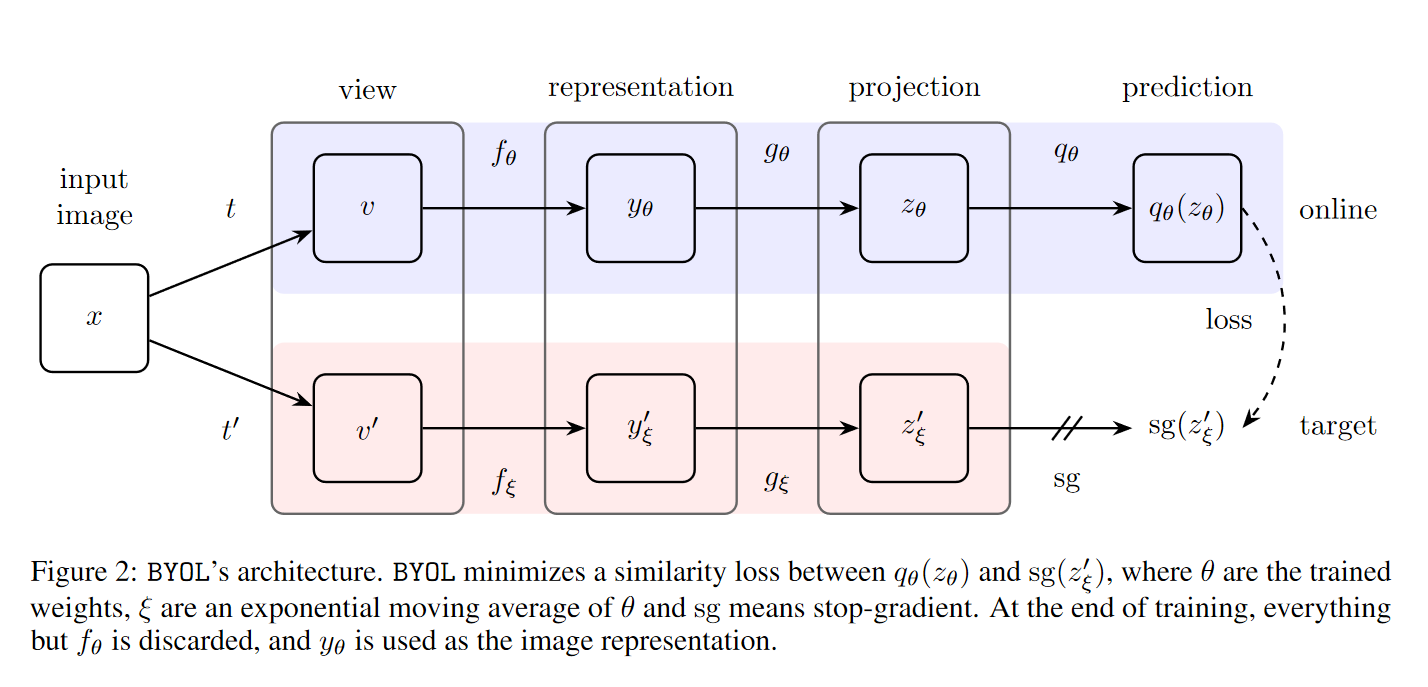

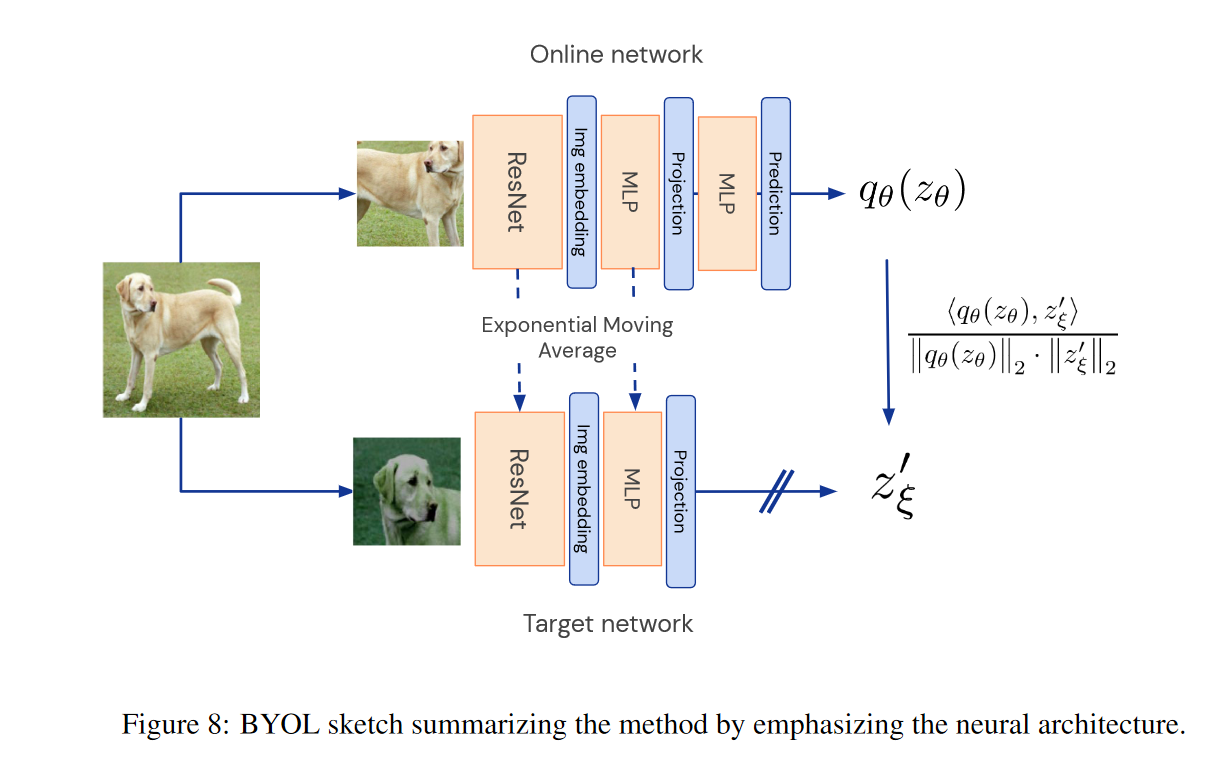

### Augmentacja

Dodatek B publikacji opisuje augmentacje zastosowane w metodzie BYOL. Zwróć uwagę na tabelę 6 w publikacji. `torchvision.transforms.RandomApply` może być pomocne. 

***Zaimeplementuj*** augmentację $\tau$ i $\tau'$.


In [3]:
def T(image):
  transform = transforms.Compose([transforms.RandomApply([transforms.RandomResizedCrop(size=(224, 224))],p=1.0),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)],p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.RandomApply([transforms.GaussianBlur(kernel_size=(23, 23), sigma=(0.1, 2))],p=1.0),
                                      ])
  image = transform(image)
  return image

def T_prim(image):
  transform = transforms.Compose([transforms.RandomApply([transforms.RandomResizedCrop(size=(224, 224))],p=1.0),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)],p=0.8),
                                      transforms.RandomGrayscale(p=0.2),
                                      transforms.RandomApply([transforms.GaussianBlur(kernel_size=(23, 23), sigma=(0.1, 2))],p=1.0),
                                      transforms.RandomSolarize(threshold=1.0,p=0.2)
                                      ])
  image = transform(image)
  return image

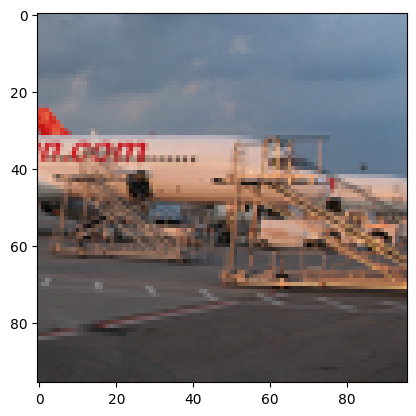

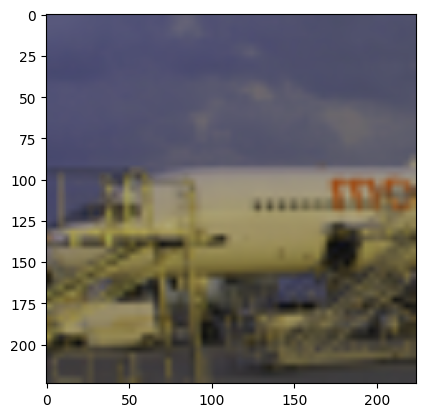

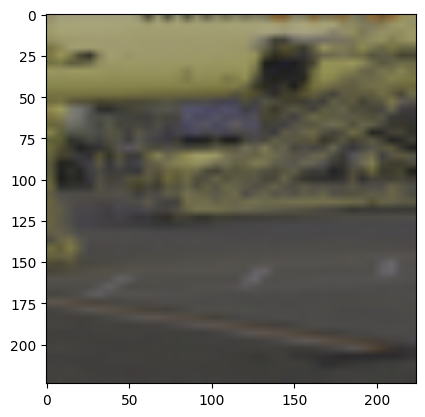

In [10]:
import matplotlib.pyplot as plt
img, label = test[3]

plt.imshow(img.permute(1,2,0))
plt.show()

img, label = test[3]
img = T(img)
plt.imshow(img.permute(1,2,0))
plt.show()

img, label = test[3]
img = T_prim(img)
plt.imshow(img.permute(1,2,0))
plt.show()

### Implementacja uczenia samonadzorowanego

***Zaprogramuj*** proces uczenia samonadzorowanego na danych nieetykietowanych ze zbioru STL10.

Wskazówki do realizacji polecenia:

1. Proces uczenia może trwać bardzo długo dlatego zaleca się zastsowanie wczesnego zatrzymania lub uczenia przez tylko jedną epokę. Mimo wszystko powinno się dać osiągnąć poprawę w uczeniu nadzorowanym wykorzystując tylko zasoby z Google Colab.
2. Dobrze jest pominąć walidację na zbiorze treningowym i robić ją tylko na zbiorze walidacyjnym - zbiór treningowy jest ogromny i w związku z tym narzut czasowy na walidację też będzie duży.
3. Walidację modelu można przeprowadzić na zbiorze `train` lub całkowicie ją pominąć, jeżeli uczymy na stałej ilości epok.
4. Rozważ zastosowanie tylko jednej augmentacji - augmentacja $\tau'$ jest bardziej czasochłonna niż $\tau$.
5. Poniżej jest zaprezentowany zalążek kodu - jest on jedynie wskazówką i można na swój sposób zaimplementować tę metodę

In [4]:
from copy import deepcopy
from torch import nn
import torch.nn.functional as F
import gc


class mlp(nn.Module):
    def __init__(self,encoder_out_shape,projection_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(encoder_out_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, projection_size)
        )
    def forward(self,x):
      batch_size = x.shape[0]
      x = x.view(batch_size, -1)
      return self.net(x)

def loss_fn(x, y):
    x = F.normalize(x, dim=1)
    y = F.normalize(y, dim=1)
    return 2 - 2 * (x * y).sum(dim=-1)

class BYOL(nn.Module):
    def __init__(self, model, labels_no, augmentation, augmentation_prim, encoder_out_shape = 1000, projection_size = 256, tau = 0.999):
        super().__init__()
        self.encoder_online = model
        self.projector_online = mlp(encoder_out_shape, projection_size=projection_size)
        self.online_common = nn.Sequential(self.encoder_online, self.projector_online)
        self.predictor_online = nn.Linear(projection_size, projection_size)
        self.online = nn.Sequential(self.online_common, self.predictor_online)

        self.encoder_target = deepcopy(self.encoder_online)
        self.projector_target = deepcopy(self.projector_online)
        self.target = nn.Sequential(self.encoder_online, self.projector_online)

        self.tau = tau
        self.augmentation = augmentation
        self.augmentation_prim = augmentation_prim

    def forward(self,x):
        img_1=self.augmentation(x)
        img_2=self.augmentation_prim(x)

        res_1 = self.online(img_1)
        with torch.no_grad():
            res_2 = self.target(img_2)
        
        return loss_fn(res_1,res_2).mean()

    def update_moving_average(self): 
          with torch.no_grad():
              for param_target, param_online in zip(self.target.parameters(), self.online_common.parameters()):
                  param_target = self.tau * deepcopy(param_target) + (1 - self.tau) * deepcopy(param_online)



In [5]:
def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    all = 0
    for X_batch, y_batch in dataloader:
        all += len(X_batch)
        loss += model(X_batch.cuda())
        del X_batch
        gc.collect()
        torch.cuda.empty_cache()
    return loss / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          loss = model(X_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()
          model.update_moving_average()
          del X_batch
          gc.collect()
          torch.cuda.empty_cache()
      
      if print_metrics: 
          model.eval()
          with torch.no_grad():
              val_loss = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"validation loss = {val_loss:.3f}"
              )

In [16]:
resnet = models.resnet18(weights='DEFAULT')

byol = BYOL(model=resnet,labels_no=10,augmentation=T, augmentation_prim=T).cuda()
optimizer = optim.Adam(byol.parameters())
fit(byol, optimizer, loss_fn, unlabeled_dataloader, test_dataloader, epochs=1)


100%|██████████| 391/391 [10:19<00:00,  1.58s/it]


Epoch 0: validation loss = 0.001


In [18]:
def accuracy(pred: torch.Tensor, labels: torch.Tensor) -> float:
    return (pred.argmax(dim=-1) == labels).float().mean().item()


acc = sum([accuracy(byol(x.cuda()), y.cuda()) for x, y in test_dataloader]) / len(test_dataloader)
print(f"Accuracy: {acc:.3f}")

Accuracy: 0.100


## Douczanie nadzorowane

***Zaimplementuj*** proces douczania kodera z poprzedniego polecenia na danych etykietowanych ze zbioru treningowego. Porównaj jakość tego modelu z modelem nauczonym tylko na danych etykietownaych. Postaraj się wyjaśnić różnice.

In [19]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from typing import Tuple
from tqdm import tqdm

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})")

In [22]:
state_dict = byol.encoder_online.state_dict()
encoder = models.resnet18(pretrained=False).cuda()
encoder.load_state_dict(state_dict)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
fit(encoder, optimizer, loss_fn, train_dataloader, test_dataloader, 15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


Epoch 0: train loss = 0.032 (acc: 0.000), validation loss = 0.032 (acc: 0.000)


100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


Epoch 1: train loss = 0.020 (acc: 0.101), validation loss = 0.020 (acc: 0.105)


100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch 2: train loss = 0.011 (acc: 0.115), validation loss = 0.011 (acc: 0.114)


100%|██████████| 20/20 [00:03<00:00,  5.93it/s]


Epoch 3: train loss = 0.009 (acc: 0.163), validation loss = 0.009 (acc: 0.163)


100%|██████████| 20/20 [00:03<00:00,  5.45it/s]


Epoch 4: train loss = 0.009 (acc: 0.165), validation loss = 0.009 (acc: 0.158)


100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 5: train loss = 0.009 (acc: 0.159), validation loss = 0.009 (acc: 0.158)


100%|██████████| 20/20 [00:03<00:00,  5.30it/s]


Epoch 6: train loss = 0.008 (acc: 0.202), validation loss = 0.008 (acc: 0.200)


100%|██████████| 20/20 [00:03<00:00,  5.73it/s]


Epoch 7: train loss = 0.008 (acc: 0.232), validation loss = 0.008 (acc: 0.227)


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


Epoch 8: train loss = 0.008 (acc: 0.222), validation loss = 0.008 (acc: 0.224)


100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


Epoch 9: train loss = 0.008 (acc: 0.259), validation loss = 0.008 (acc: 0.251)


100%|██████████| 20/20 [00:03<00:00,  6.08it/s]


Epoch 10: train loss = 0.008 (acc: 0.276), validation loss = 0.008 (acc: 0.272)


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Epoch 11: train loss = 0.007 (acc: 0.293), validation loss = 0.007 (acc: 0.278)


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


Epoch 12: train loss = 0.007 (acc: 0.312), validation loss = 0.007 (acc: 0.298)


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]


Epoch 13: train loss = 0.007 (acc: 0.303), validation loss = 0.007 (acc: 0.294)


100%|██████████| 20/20 [00:03<00:00,  6.02it/s]


Epoch 14: train loss = 0.007 (acc: 0.304), validation loss = 0.007 (acc: 0.293)
